In [105]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import matplotlib.pyplot as plt                           #importing matplotlib 
import seaborn as sns                                     #importing seaborn
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.linear_model import LinearRegression         #importing scikit-learn's linear regressor function
from sklearn.neural_network import MLPRegressor           #importing scikit-learn's neural network function
from sklearn.ensemble import GradientBoostingRegressor    #importing scikit-learn's gradient booster regressor function
from sklearn.metrics import mean_squared_error            #importing scikit-learn's root mean squared error function for model evaluation
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function
import random

In [106]:
boxscores = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/boxscores_dataset.csv')     #load boxscores dataset
# running locally
# boxscores = pd.read_csv('boxscores_dataset.csv')     #load boxscores dataset
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

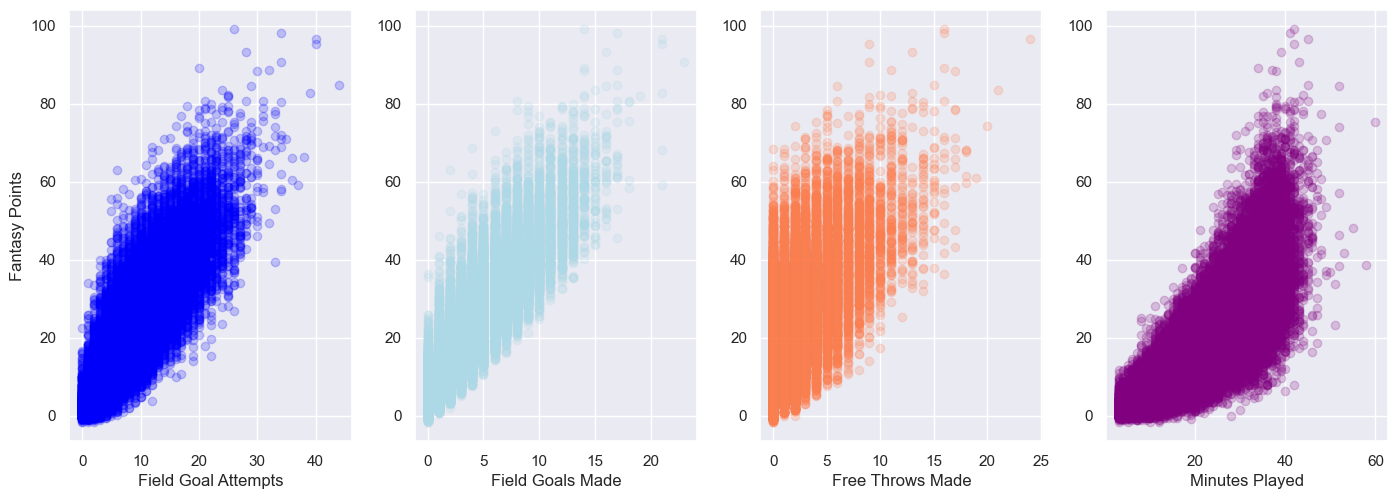

In [107]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Field Goal Attempts')
FGM.set_xlabel('Field Goals Made')
FTM.set_xlabel('Free Throws Made')
Min.set_xlabel('Minutes Played')

FGA.set_ylabel('Fantasy Points');

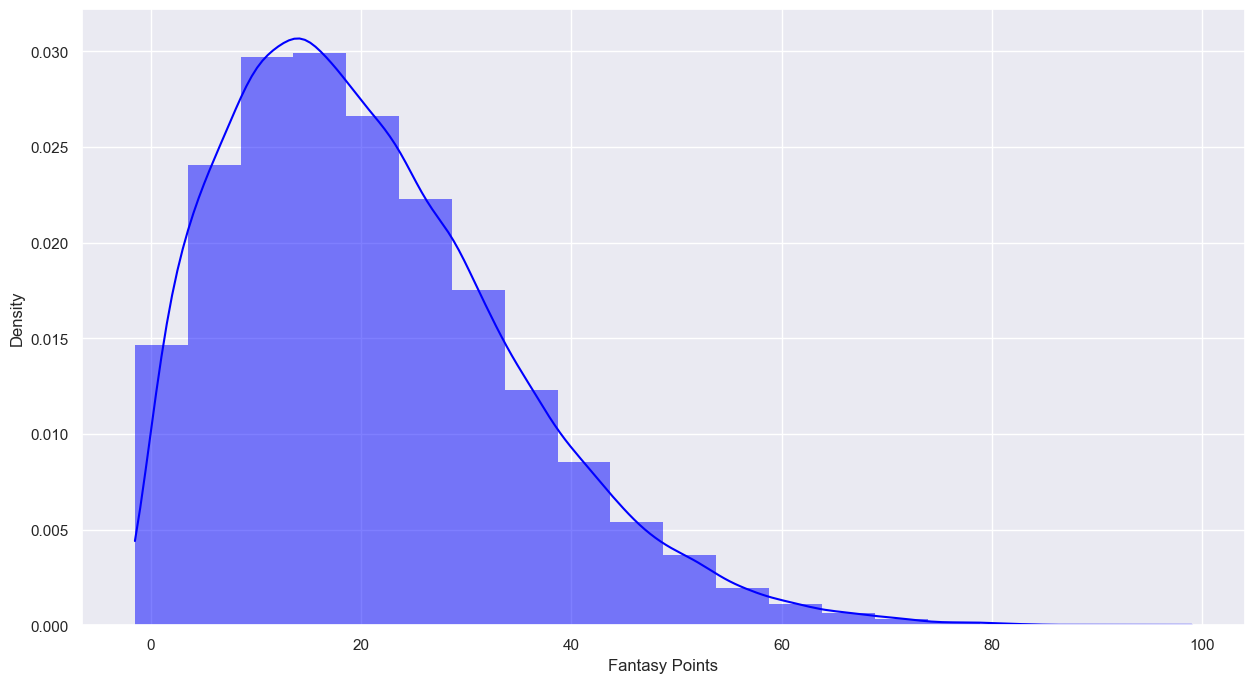

In [108]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

In [109]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))
print(boxscores)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr teamConf    teamDiv teamLoc  ... movingplayBLK  movingplayTRB movingplayFGA movingplayFTA movingplay2P% movingplay3P% movingplayFT% movingplayMin movingteamDayOff movingFantasyPoints
0             226  2016-10-26   8:00  Regular  Abrines  Alejandro      OKC     West  Northwest    Away  ...           NaN            NaN           NaN           NaN           NaN           NaN           NaN           NaN              NaN                 NaN
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC     West  Northwest    Away  ...      0.000000       1.000000      2.000000      0.000000      0.000000      1.000000      0.000000     13.000000         0.000000            3.750000
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC     West  Northwest    Away  ...      0.000000       0.500000      2.000000      0.000000      0.000000      1.000000      0.000000     10.500000      

In [110]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)  

In [111]:
print(boxscores)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr teamConf    teamDiv teamLoc  ... movingplayBLK  movingplayTRB movingplayFGA movingplayFTA movingplay2P% movingplay3P% movingplayFT% movingplayMin movingteamDayOff movingFantasyPoints
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC     West  Northwest    Away  ...      0.000000       1.000000      2.000000      0.000000      0.000000      1.000000      0.000000     13.000000         0.000000            3.750000
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC     West  Northwest    Away  ...      0.000000       0.500000      2.000000      0.000000      0.000000      1.000000      0.000000     10.500000         1.500000            4.875000
4            1724  2016-11-05   6:00  Regular  Abrines  Alejandro      OKC     West  Northwest    Home  ...      0.000000       1.333333      3.333333      0.666667      0.000000      0.722233      0.333333     13.333333      

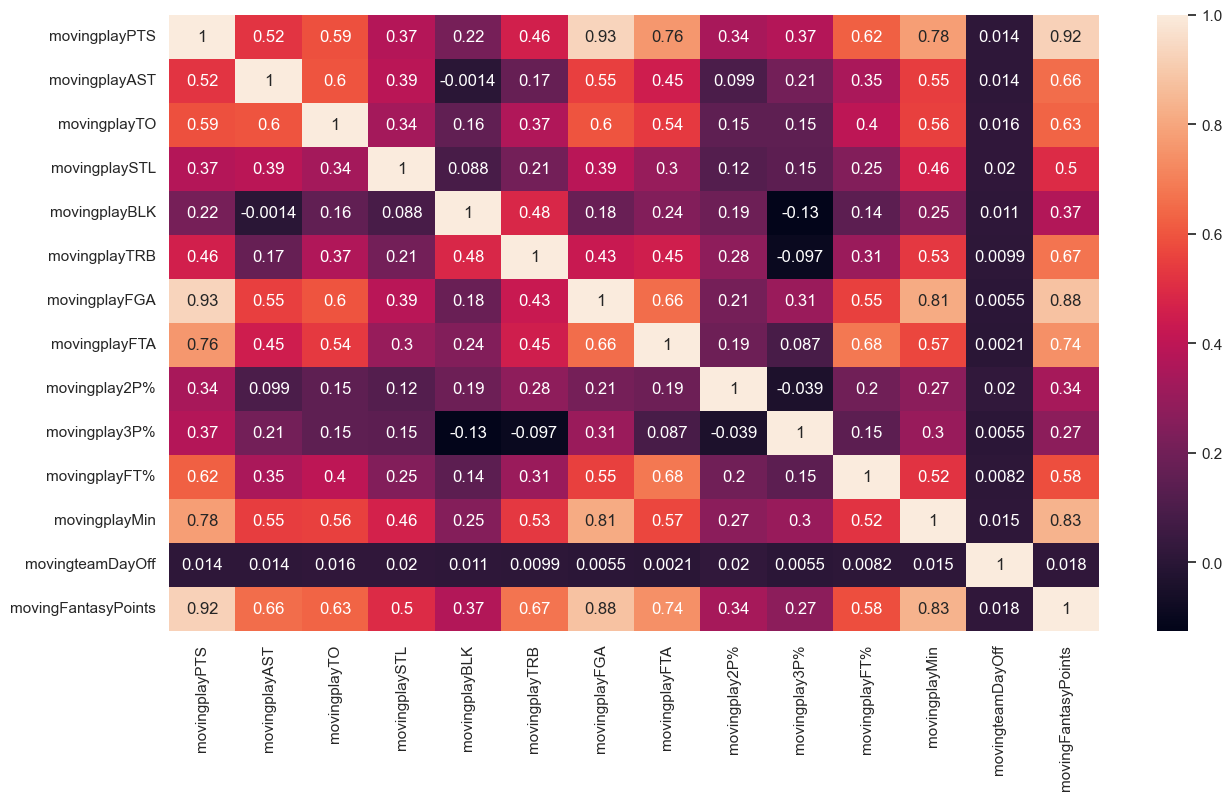

In [112]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

In [113]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1 if the game is a home game, 0 if it is an away game
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1 if the player starts, 0 if the player comes from the bench

In [114]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']  #for model training, we exclude observation on December 25, 2017

In [115]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #select the features that will be used for model training
y = forecasting_data['FantasyPoints']  #target set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #dataset splitting

linear_regressor = LinearRegression()                                                         #load linear regressor
linear_regressor.fit(X_train, y_train)                                                        #train the linear regression model
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

mlp = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu')                               #load neural network
mlp.fit(X_train,y_train)                                                                      #train the neural network with a ReLU function and two hidden layers with 5 nodes each
mlp_validation = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

gb = GradientBoostingRegressor()                                                              #load a gradient boosting regressor
gb.fit(X_train, y_train)                                                                      #train a gradient boosting model
gb_validation = cross_validate(gb, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

c:\Users\mar\anaconda3\envs\hw3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [116]:
gb_validation['test_score']  

array([0.50948155, 0.49917309, 0.48133319, 0.49762372, 0.50076644])

In [117]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #make predictions based on the test set for the linear regression model
mlp_predictions = mlp.predict(X_test)                                                         #make predictions based on the test set for the neural network model
gb_predictions = gb.predict(X_test)                                                           #make predictions based on the test set for the gradient boosting model

linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #calculate the MSE for the linear regression model
mlp_mse = mean_squared_error(y_test, mlp_predictions)                                         #calculate the MSE for the neural network model
gb_mse = mean_squared_error(y_test, gb_predictions)                                           #calculate the MSE for the gradient boosting model

results = {'Linear Regression':[linear_regression_mse],'ReLU Neural Network':[mlp_mse],'Gradient Boosting Regressor':[gb_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,Linear Regression,ReLU Neural Network,Gradient Boosting Regressor
MSE,91.077312,90.828064,90.669304


Text(968.0882352941177, 0.5, 'Gradient Boosting Residual')

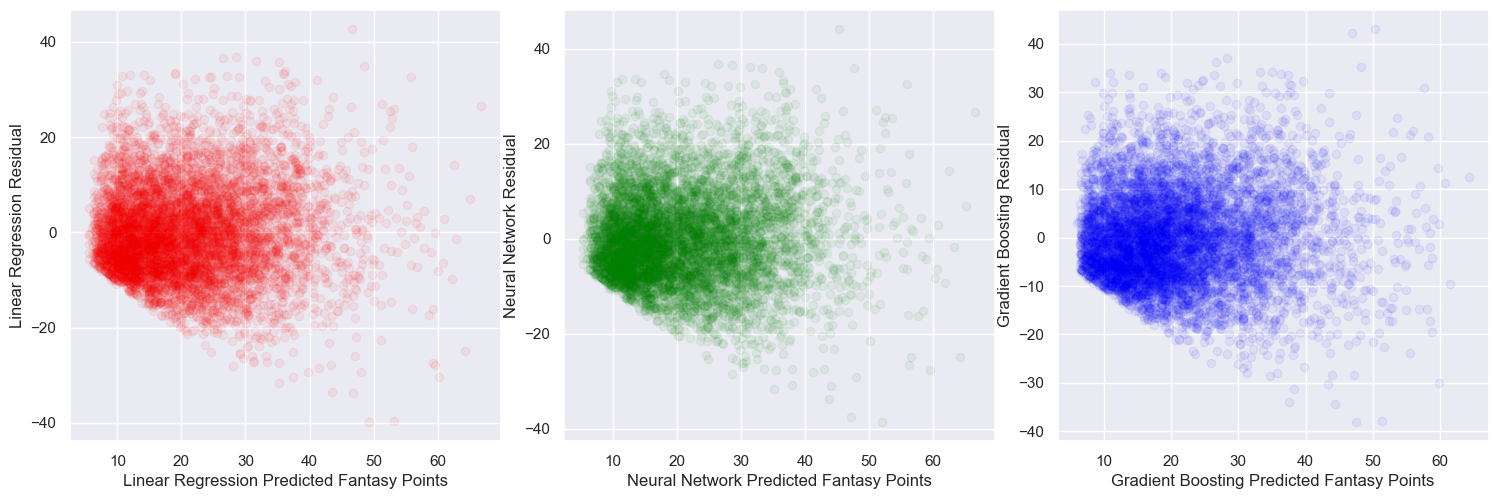

In [118]:
fig, (LR, FNN, GBR) = plt.subplots(1, 3,figsize=(15,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
FNN.scatter(x = mlp_predictions, y = y_test - mlp_predictions, color='green',alpha=0.06)
GBR.scatter(x = gb_predictions, y = y_test - gb_predictions, color='blue',alpha=0.06)

LR.set_xlabel('Linear Regression Predicted Fantasy Points')
FNN.set_xlabel('Neural Network Predicted Fantasy Points')
GBR.set_xlabel('Gradient Boosting Predicted Fantasy Points')

LR.set_ylabel('Linear Regression Residual')
FNN.set_ylabel('Neural Network Residual')
GBR.set_ylabel('Gradient Boosting Residual')

In [119]:
gb_final = GradientBoostingRegressor(random_state=4)                                                             
gb_final.fit(X, y)   

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = gb_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]) 

player_results = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/target_games.csv')
# player_results = pd.read_csv('target_games.csv')

predicted_fantasy_points = (
    optimization_dataset.query("gmDate == '2017-12-25'")
    [["playDispNm", "PredictedFantasyPoints"]]
)

player_results = pd.merge(
    left = player_results,
    right = predicted_fantasy_points,
    left_on = "Player",
    right_on = "playDispNm",
)

In [120]:
print(player_results)

               Player Pos Team     Opp  Salary         playDispNm  PredictedFantasyPoints
0        James Harden  PG  HOU   @ OKC   11100       James Harden               48.809577
1        LeBron James  SF  CLE   @ GSW   11000       LeBron James               48.149718
2   Russell Westbrook  PG  OKC  vs HOU   10900  Russell Westbrook               44.007224
3        Kevin Durant  SF  GSW  vs CLE   10500       Kevin Durant               43.438575
4         Joel Embiid   C  PHI   @ NYK    9500        Joel Embiid               51.313689
..                ...  ..  ...     ...     ...                ...                     ...
91       Andrew Bogut   C  LAL  vs MIN    3000       Andrew Bogut               18.518728
92        Alex Caruso  PG  LAL  vs MIN    3000        Alex Caruso                6.896506
93      Briante Weber  PG  HOU   @ OKC    3000      Briante Weber               11.745820
94         Cedi Osman  SG  CLE   @ GSW    3000         Cedi Osman                8.071501
95       J

In [121]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #we multiple the fantasy vs salary ratio by 1000 for better visualization
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,playDispNm,PredictedFantasyPoints,Points/Salary Ratio
4,Joel Embiid,C,PHI,@ NYK,9500,Joel Embiid,51.313689,5.401441
0,James Harden,PG,HOU,@ OKC,11100,James Harden,48.809577,4.397259
1,LeBron James,SF,CLE,@ GSW,11000,LeBron James,48.149718,4.377247
2,Russell Westbrook,PG,OKC,vs HOU,10900,Russell Westbrook,44.007224,4.037360
3,Kevin Durant,SF,GSW,vs CLE,10500,Kevin Durant,43.438575,4.137007


In [122]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
S = 30000
positions = dict(zip(indices, player_results.Pos))


## Definimos los parámetros

In [321]:
# Lista de posiciones que deben ser cubiertas en cada equipo
posiciones = ["C", "PG", "SG", "SF", "PF"] 
# Crear un diccionario con los jugadores agrupados por posición
jugadores_por_posicion = {pos: [nombre for nombre in indices if positions[nombre] == pos] 
                          for pos in posiciones}
#número máximo de iteraciones (itera)
num_generaciones = 100
#tamaño de la población
tamanoPoblacion= 50
#tasa mutación
mu=0.5
# porcentaje de cruzamiento
pc = 0.5
# numero de hijos descencientes (nc)
num_equipos = 20
#número de descendientes mutados
nm=round(0.3*tamanoPoblacion)   

## Definimos las funciones

### Fitness
Aquí ya iría incluido el límite de que el salario no puede ser mayor que S, así que no lo tenemos que tener en cuenta más tarde

In [322]:
def calcular_fitness(row):
    """
    Calcula el fitness de un equipo basado en la suma de los puntos de los jugadores seleccionados.
    Penaliza si el presupuesto excede el máximo permitido.
    """
    puntos_totales = 0
    salario_total = 0
    
    for pos in posiciones:
        jugador = row[pos]  # Obtiene el nombre del jugador en la posición 'pos'
        puntos_totales += points[jugador]  # Suma los puntos del jugador
        salario_total += salaries[jugador]  # Suma el salario del jugador
    
    if salario_total > S:
        return 0  # Penalización si el equipo excede el presupuesto
    else:
        return puntos_totales

### Creacion la población

In [323]:
def creacion_poblacion():
    """
    Crea una población de equipos con jugadores aleatorios asignados a cada posición.
    """
    # Crear el DataFrame de la población
    pob = pd.DataFrame(index=range(tamanoPoblacion))
    pob['Equipo'] = range(0, tamanoPoblacion)
    
    # Asignar jugadores aleatorios a cada posición en el equipo
    for pos in posiciones:
        pob[pos] = [random.choice(jugadores_por_posicion[pos]) for _ in range(tamanoPoblacion)]
    
    # Calcular el fitness de cada equipo
    pob['Fitness'] = pob.apply(calcular_fitness, axis=1)
    
    return pob

### Seleccion
Más cómodo que como estaba implementada con cumsum, que también está basada en ruleta

In [324]:
def seleccion_ruleta(poblacion_df):
    """
    Selecciona dos padres basados en el fitness (ruleta).
    
    :param poblacion_df: DataFrame que contiene la población de equipos
    :return: Dos padres seleccionados de la población
    """
    fitness_vals = poblacion_df["Fitness"].values
    total_fitness = sum(fitness_vals)

    if total_fitness == 0:
        return poblacion_df.sample(n=2).iloc[:2].to_dict("records")  # Evita división por cero y selecciona aleatoriamente

    # Calcular las probabilidades basadas en el fitness
    probabilidades = [f / total_fitness for f in fitness_vals]

    # Selección del primer padre
    padre_1 = poblacion_df.sample(n=1, weights=probabilidades).iloc[0]

    # Selección del segundo padre
    padre_2 = poblacion_df.sample(n=1, weights=probabilidades).iloc[0]

    return padre_1, padre_2

### Cruce: intercambiar jugadores
La clave ha sido coger el máximo entre los puntos de los padres para pasar esa cualidad al hijo.
En otra versión simplemente intercambiaba de manera random ambos, pero no me convergía. Ahora converge y más rápido.

In [325]:
def cruce(padre1, padre2):
    """
    Intercambia aleatoriamente jugadores entre los equipos manteniendo restricciones.
    """
    hijo1, hijo2 = padre1.copy(), padre2.copy()  # Asegúrate de copiar las estructuras

    for pos in posiciones:
        if random.random() > pc:  # 50% de probabilidad de intercambiar un jugador
            if points[hijo1[pos]] > points[hijo2[pos]]:
                hijo2[pos] = hijo1[pos]
            else:
                hijo1[pos] = hijo2[pos]
    
    return hijo1, hijo2


### Mutación: cambiar un jugador aleatoriamente

In [326]:
def mutacion(equipo):
    """
    Cambia aleatoriamente un jugador en una posición con probabilidad tasa_mutacion.
    """
    for pos in posiciones:
        if random.random() < mu:
            equipo[pos] = random.choice(jugadores_por_posicion[pos]) 
    
    return equipo


## Implementación GA

In [329]:
# Inicialización de la población
poblacion_df = creacion_poblacion()

# Bucle principal
for gen in range(num_generaciones):
    
    # Hacer una copia de la población para trabajar en ella sin alterar la original
    P = poblacion_df.copy()
    nueva_poblacion = []
    
    # Realizar cruce para obtener nuevos hijos
    for j in range(tamanoPoblacion // 2):  # Cruce en pares
        # Selección de los padres
        padre1, padre2 = seleccion_ruleta(P)
        
        # Realización del cruce
        hijo1, hijo2 = cruce(padre1, padre2)

        # Calcular el fitness de los hijos
        hijo1['Fitness'] = calcular_fitness(hijo1)
        hijo2['Fitness'] = calcular_fitness(hijo2)

        nueva_poblacion.append(hijo1)
        nueva_poblacion.append(hijo2)
        

    # Aplicar la mutación a una fracción de la población
    for k in range(nm):
        z=random.randint(0,len(P)-1)
        p=P.iloc[z]
        equipo = p.copy()
        hijo_mutado = mutacion(equipo)
        
        # Calcular el fitness de los mutados
        hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
        
        # Reemplazar al hijo con el mutado
        nueva_poblacion.append(hijo_mutado)
        
    # Convertir la lista de nueva población a un DataFrame
    nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
    
    # Concatenar la nueva población con la población existente (actualizar poblacion_df)
    poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
    
    mejor = poblacion_df.sort_values(by="Fitness", ascending=False).iloc[0]
    
    #print("mejor equipo en iteracion ", gen, mejor['Fitness'])

# Mostrar el mejor equipo encontrado
mejor_equipo = poblacion_df.sort_values(by="Fitness", ascending=False).iloc[0]
print("Mejor equipo encontrado:\n", mejor_equipo)




Mejor equipo encontrado:
 Equipo                  25
C              Joel Embiid
PG            Jarrett Jack
SG            Trevor Ariza
SF         Markieff Morris
PF             Dario Saric
Fitness         171.918929
Name: 5194, dtype: object


## Resultado final

In [ ]:
print("\nEquipo óptimo seleccionado:")
for pos in posiciones:
    jugador = mejor_equipo[pos]
    print(f"{jugador} - Posición: {pos}, FantasyPoints: {points[jugador]}, Salary: {salaries[jugador]}")


Equipo óptimo seleccionado:
Joel Embiid - Posición: C, FantasyPoints: 51.31368913047382, Salary: 9500
Jarrett Jack - Posición: PG, FantasyPoints: 27.780012412781506, Salary: 4600
Trevor Ariza - Posición: SG, FantasyPoints: 26.354156526577885, Salary: 5000
Markieff Morris - Posición: SF, FantasyPoints: 25.96558495634552, Salary: 4400
Dario Saric - Posición: PF, FantasyPoints: 40.5054861101437, Salary: 6200


In [ ]:
results['True Fantasy Points'] = [53.5,17.25,28.5,15.5,29.25]
results

{'Linear Regression': [91.07731216428819],
 'ReLU Neural Network': [90.82806428433659],
 'Gradient Boosting Regressor': [90.66930378998275],
 'True Fantasy Points': [53.5, 17.25, 28.5, 15.5, 29.25]}

# Comentario para futuras mejoras
Para el cruce creo que ya he dado en el clavo. Para mutación podríamos ir reduciendo cada vez más el parámetro para que al principio explore más pero luego se vuelva más conservador. También se podría tener en cuenta el salrario por posición a la hora de mutar. O añadir los meejores mutados en muy poquito, para ir mejorando sobre lo ya mejor.... No sé, dale una vuelta

También me raya el cocepto de mutación, porque en GA_def_v2 se define como mutación de los descendientes y en el video que me vi también, sin embargo, cuando se usa no se usa sobre los descendientes sino sobre la población general. Me gustaría estudiar esto. Porque igual por eso veo mutación tan inútil pero no lo es.

Por otro lado, deberíamos ir actualizando constantemente el tamaño de la población? Porque actualmente tal y como está, aunque la población crece este valor no cambia.... Pasa lo mismo en GA_def_v2

También estaría bien que se mostraran gráficas de mejor resultado y demás como en el código del profe.